In [1]:
# Import essential libraries
import numpy as np  # for mathematical functions 

import matplotlib.pyplot as plt # for plotting the graphs

import seaborn as sns; sns.set_theme(style='darkgrid') # helps to plot statistical data 

import copy # create deep/shallow copy of objs an prevent accidental modifications 

import torch # for building nn and cnns

import torchvision # for image manipulations (image datasets)

import torchvision.transforms as transforms  # for tranforming images 

from torch.optim.lr_scheduler import ReduceLROnPlateau #educes lr based on models performance

import torch.nn as nn # used for defining our own classes

from torchsummary import summary # useful for summary abt the layers 

import torch.nn.functional as F # mutilple activation functions


import pathlib # contains classes which have fucntions to manage the paths

from sklearn.metrics import confusion_matrix, classification_report #for model eval

from tqdm.notebook import trange, tqdm #for progress bars

from torch import optim # for various optimization algo 


In [2]:
# dataset path
data_dir = 'C:\\Users\\Alsa Munir\\Downloads\\brain'
data_dir = pathlib.Path(data_dir)


In [3]:
# define transformation
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Define an object of the custom dataset for the train and validation.
data_dir = 'C:\\Users\\Alsa Munir\\Downloads\\brain'
data_dir = pathlib.Path(data_dir)
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform) 
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)


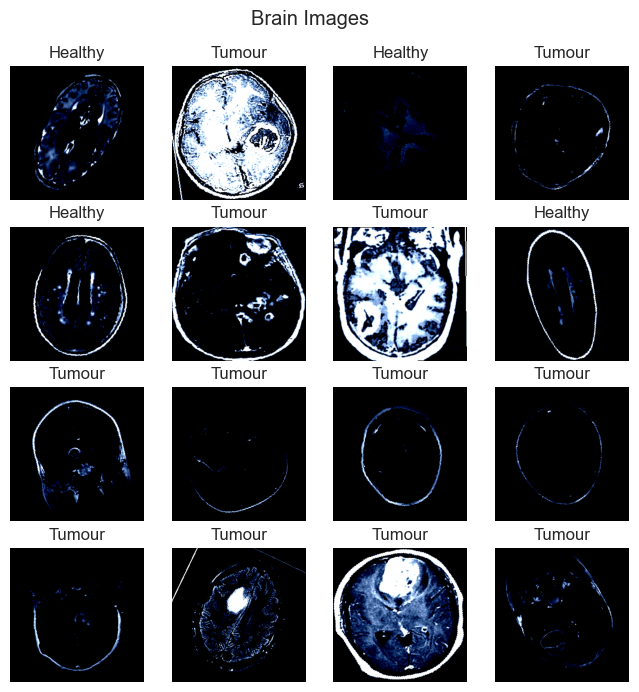

In [5]:
# Visualize some images from Train Set
CLA_label = {
    1 : 'Tumour',
    0 : 'Healthy'
} 
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
plt.suptitle('Brain Images', y=0.95)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
plt.show()

In [6]:
# import and load train, validation
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False, num_workers = 2)


In [7]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        #images and their labels
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



In [8]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [9]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [10]:
params_model={
        "shape_in": (3,256,256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [11]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


In [12]:
loss_func = nn.NLLLoss(reduction="sum")


In [13]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

c:\Users\Alsa Munir\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [15]:
def Train_Val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

    
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [16]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 8,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/8 [00:00<?, ?it/s]

<Axes: >

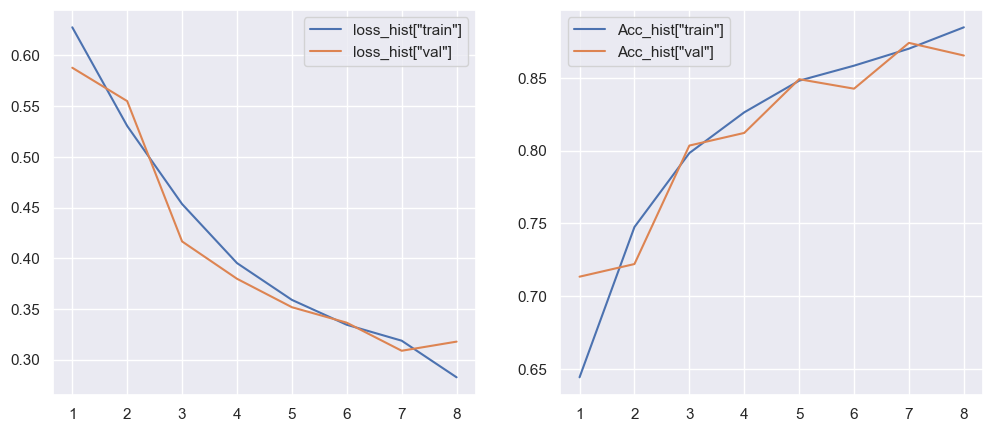

In [17]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')

sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

In [18]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       418
         1.0       0.90      0.86      0.88       503

    accuracy                           0.88       921
   macro avg       0.87      0.88      0.88       921
weighted avg       0.88      0.88      0.88       921
 




In [19]:
torch.save(cnn_model, "Brain_Tumor_model.pt")


In [21]:
from PIL import Image
# Load the single image
image_path = "C:\\Users\\Alsa Munir\\OneDrive\\Desktop\\To Submit\\To Submit\\Code+DataSet\\BrainTumorDetection\\h.jpg"
image = Image.open(image_path)

# Define the transformations to be applied
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transformations
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_image = input_image.to(device)

# Pass the input image through the model
with torch.no_grad():
    output = cnn_model(input_image)

# Get the predicted class
_, predicted = torch.max(output, 1)

# Convert the predicted class tensor to a numpy array
predicted_class = predicted.item()

# You can then use the predicted class to interpret the result or take further actions based on your application's requirements
print("Predicted Class:", CLA_label[predicted_class])

Predicted Class: Healthy
